In [1]:
import pandas as pd
import altair as alt
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
articles = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv')
transactions = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

In [4]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


# EDA of H&M `Customers` 🛃

 #### Age Group of Customers

In [7]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


**Fill missing age with median customer age**

In [8]:
median_customer_age = customers['age'].median()
customers['age'].fillna(median_customer_age, inplace = True)

In [9]:
customers_age = customers.groupby('age').agg({'customer_id':'count'}).rename(columns={'customer_id':'count'}).reset_index()

In [10]:
customers_age.head()

,age,count
0,16.0,161
1,17.0,9392
2,18.0,24323
3,19.0,37707
4,20.0,55196


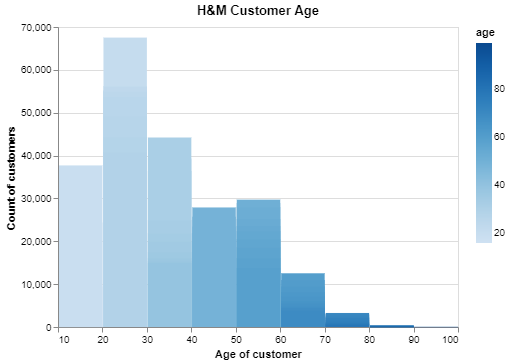

In [11]:
chart = alt.Chart(customers_age, title='H&M Customer Age').encode(x=alt.X('age', bin=alt.Bin(step=10), title='Age of customer'),
                                        y=alt.Y('count', title = 'Count of customers'),
                                        color='age').mark_bar()
chart

_It can be observed from age plot that most of the H&M customers 20-40 which makes sense too as fast fashion brands usually influence youngesters._

The kind of articles H&M markets based on their articles `detailed description`

(-0.5, 399.5, 199.5, -0.5)

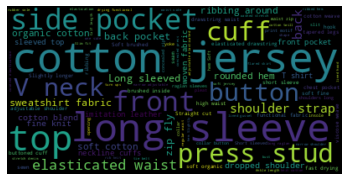

In [12]:
wordcloud = WordCloud(max_font_size=50).generate(' '.join(articles['detail_desc'].dropna()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [13]:
transactions['year'] = pd.to_datetime(transactions['t_dat']).dt.year
transactions['month'] = pd.to_datetime(transactions['t_dat']).dt.month

In [14]:
transactions_by_year_month = transactions.groupby(['year', 'month']).agg({'t_dat':'count',
                                                                          'price':'sum'}).rename(columns={'t_dat':'count',
                                                                                                          'price':'net_transaction_value'}).reset_index()

**Past Transaction history by `year` and `month`**

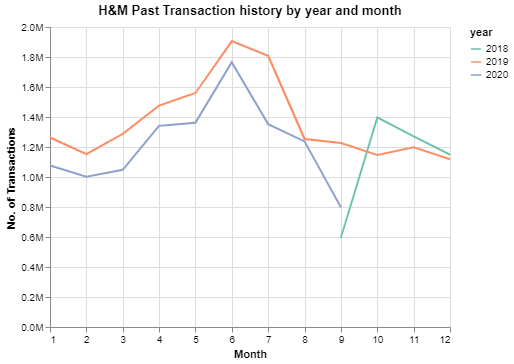

In [15]:
chart2 = (alt.Chart(transactions_by_year_month, title='H&M Past Transaction history by year and month')
             .encode(x=alt.X('month', title='Month'),
                     y=alt.Y('count', title='No. of Transactions', axis=alt.Axis(format='s')),
                     color=alt.Color('year:O', scale=alt.Scale(scheme='set2'))).mark_line())

chart2

_From past transaction history, both 2019 and 2020 seems to follow similar trend for the past months (Jan-Sept) which somewhat indicate seasonality but comparing Sept-Dec from 2018 and 2019 doesn't show any trend._

_Also, the most sales happened during mid of the year i.e. summer season which also indicates that their summer collection is more appreciated by customers_

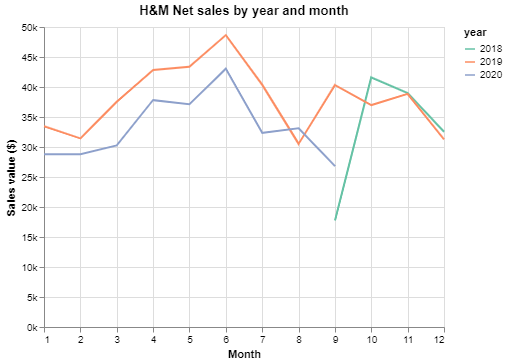

In [16]:
chart3 = (alt.Chart(transactions_by_year_month, title='H&M Net sales by year and month')
             .encode(x=alt.X('month', title='Month'),
                     y=alt.Y('net_transaction_value', title='Sales value ($)', axis=alt.Axis(format='s')),
                     color=alt.Color('year:O', scale=alt.Scale(scheme='set2'))).mark_line())

chart3

**Top 20 popular articles by past year transactions**

In [17]:
popular_articles = pd.DataFrame(transactions[['article_id']].value_counts()[:20], columns=['count']).reset_index()

In [18]:
popular_articles = popular_articles.merge(articles, on='article_id', how='inner')

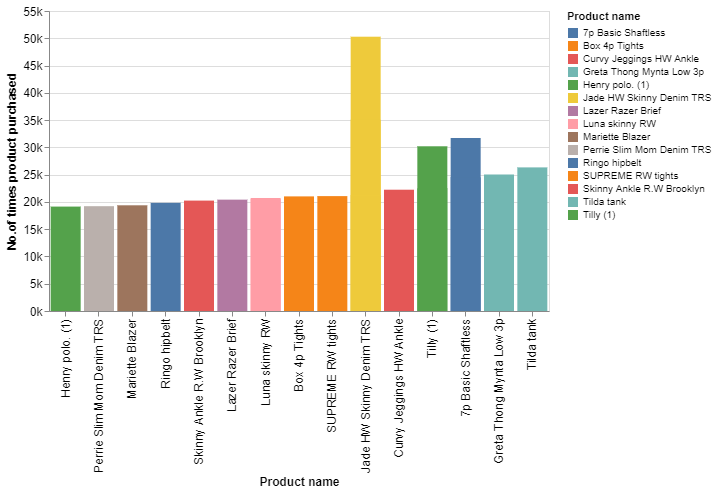

In [19]:
alt.Chart(popular_articles).encode(x=alt.X('prod_name', title='Product name', sort='y'),
                                   y=alt.Y('count', axis=alt.Axis(format='s'), title='No.of times product purchased'),
                                   color=alt.Color('prod_name', title='Product name')).mark_bar().properties(height=300, width=500).configure_axis(labelFontSize=12, titleFontSize=12)

***Popular department in H&M between 2018-2020***

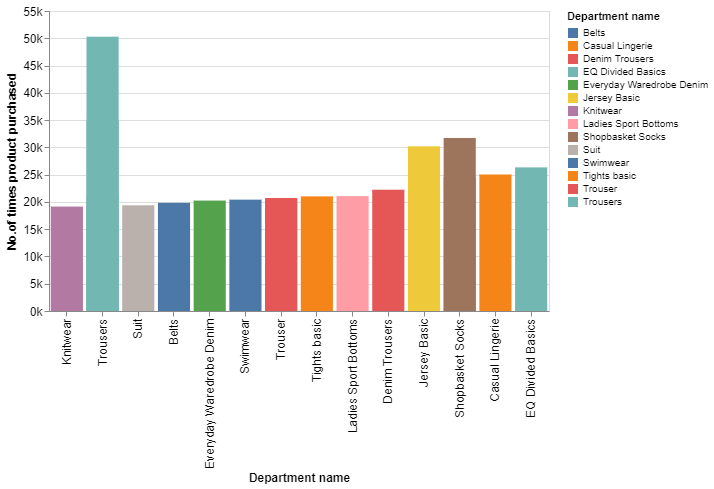

In [20]:
alt.Chart(popular_articles).encode(x=alt.X('department_name', title='Department name', sort='y'),
                                   y=alt.Y('count', axis=alt.Axis(format='s'), title='No.of times product purchased'),
                                   color=alt.Color('department_name', title='Department name')).mark_bar().properties(height=300, width=500).configure_axis(labelFontSize=12, titleFontSize=12)

In [21]:
transactions_past_sept_oct = transactions[transactions['month'].isin([9, 10])]

In [22]:
customers_in_sept_oct = transactions_past_sept_oct.groupby(['month', 'year'], as_index=False).agg({'customer_id':'count'}).rename(columns={'customer_id':'count'})

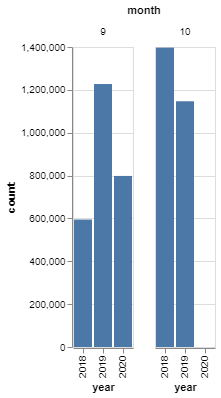

In [23]:
chart4 = (alt.Chart(customers_in_sept_oct).encode(x='year:O', y='count').mark_bar()).facet('month')

chart4

In [24]:
# recommendations for first 500 customers
customer_list = transactions_past_sept_oct['customer_id'].unique()
customer_list = customer_list[:500]

In [25]:
transactions_past_sept_oct_filter = transactions_past_sept_oct[transactions_past_sept_oct['customer_id'].isin(customer_list)]

In [26]:
article_list = transactions_past_sept_oct_filter['article_id'].unique()

In [27]:
# transactions_past_sept_oct_filter[transactions_past_sept_oct_filter['article_id'] == 663713001]
article_list = list(article_list)

In [28]:
articles = articles[articles['article_id'].isin(article_list)]

In [29]:
articles_sub = articles[['article_id','prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name'
                         ,'perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name'
                         ,'section_name','garment_group_name','detail_desc']]
articles_sub.shape

(4891, 14)

In [30]:
articles_sub['article_id'].unique()

array([108775015, 108775044, 108775051, ..., 937915002, 944506001,
       946282001])

In [31]:
# Let's remove space in all string columns
for i in articles_sub.columns[1:]:
    articles_sub[i] = articles_sub[i].str.replace(" ","")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
#Combine all info from columns to a single column separated by space

cols = ['prod_name', 'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc']
articles_sub['combined'] = articles_sub[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
articles_final = articles_sub[['article_id','combined']]

In [34]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
articles_final['combined'] = articles_final['combined'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(articles_final['combined'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(4891, 11351)

In [35]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.86775415, 0.85234196, ..., 0.00869344, 0.03258023,
        0.0711094 ],
       [0.86775415, 1.        , 0.8744503 , ..., 0.15393466, 0.03064438,
        0.02139657],
       [0.85234196, 0.8744503 , 1.        , ..., 0.06581299, 0.02384855,
        0.02124809],
       ...,
       [0.00869344, 0.15393466, 0.06581299, ..., 1.        , 0.        ,
        0.        ],
       [0.03258023, 0.03064438, 0.02384855, ..., 0.        , 1.        ,
        0.01594726],
       [0.0711094 , 0.02139657, 0.02124809, ..., 0.        , 0.01594726,
        1.        ]])

In [36]:
indices = pd.Series(articles_final['article_id']).reset_index(drop=True).drop_duplicates()

In [37]:
indices

0       108775015
1       108775044
2       108775051
3       111586001
4       111593001
          ...    
4886    936622001
4887    937252001
4888    937915002
4889    944506001
4890    946282001
Name: article_id, Length: 4891, dtype: int64

In [38]:
# Function that takes in article_id as input and outputs most similar articles
def get_recommendations(title, cosine_sim=cosine_sim):
    
    if title in indices.values:
    
        # Get the index of the article that matches the title
        idx = indices[indices == title].index[0]
        

        # Get the pairwsie similarity scores of all articles
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the articles based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar articles
        sim_scores = sim_scores[1:12]

        # Get the article indices
        article_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar articles
        return articles_final['article_id'].iloc[article_indices]
    
    else:
        return []

In [39]:
from PIL import Image

In [40]:
def display_articles(article_ids):
    rows = 4 #len(article_ids)
    cols = 3
    image_path = "../input/h-and-m-personalized-fashion-recommendations/images"
    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
    for i in range(len(article_ids)):

        article_id = ("0" + str(article_ids[i]))[-10:]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        #plt.title(f"{product_group_name} {article_id[:3]}\n{article_id}.jpg")
        try:
            image = Image.open(f"{image_path}/{article_id[:3]}/{article_id}.jpg")
            plt.imshow(image)
        except:
            None

In [41]:
df = transactions_past_sept_oct.groupby(['customer_id'])['article_id'].apply(list).reset_index()

In [42]:
df.iloc[25, 1]

[801273001, 764355001]

In [43]:
recom = list(get_recommendations(764355001))
recom

[764355004,
 640462001,
 640462002,
 552475017,
 607833002,
 552473037,
 871517014,
 552473025,
 723201002,
 697054002,
 686496004]

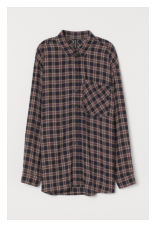

In [44]:
display_articles([764355001])

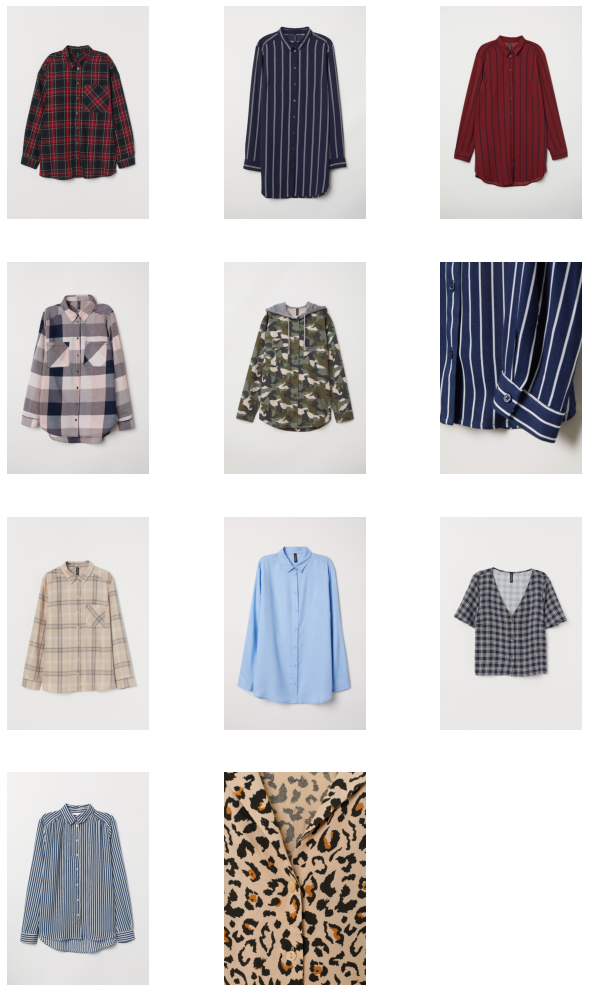

In [45]:
display_articles(recom)